<a href="https://colab.research.google.com/github/cassandra-t-ye/6.c27-Final-Project/blob/main/ComputationalPSFandNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom

Load image z-stacks

In [2]:
# Show image info
def img_info(im):
    print(f'type: {type(im)}\ndtype: {im.dtype}\nsmallest pixel value: {np.min(im)}\nlargest pixel value: {np.max(im)}')

# load an image
img = torch.from_numpy(shepp_logan_phantom())
img_dim = torch.Tensor.size(img)
# print the info
# img_info(img)

Convolve with known Gaussian PSF

In [3]:
def generate_gaussian_psf(size, omega):
    """
    Generate a Gaussian PSF.

    Parameters:
        size (int): The size of the PSF grid. The grid will be of dimensions [size x size].
        omega (float): The standard deviation of the Gaussian.

    Returns:
        torch.Tensor: A [size x size] tensor representing the Gaussian PSF.
    """
    # Create coordinate grid
    x = torch.linspace(-size // 2 + 1, size // 2, steps=size)
    y = torch.linspace(-size // 2 + 1, size // 2, steps=size)
    x, y = torch.meshgrid(x, y, indexing='xy')

    # Calculate Gaussian
    gaussian = torch.exp(-(x**2+y**2)/(2*omega**2))

    # Normalize so that the sum of all elements is 1
    gaussian = gaussian / torch.sum(gaussian)

    return gaussian

In [4]:
def fft_convolve_image(f, H):
    """
    Perform convolution of an image and a PSF using FFT.

    Parameters:
    - f (torch.Tensor): 2D tensor representing the object.
    - H (torch.Tensor): 2D tensor representing the PSF.

    Returns:
    - torch.Tensor: 2D tensor representing the convolved image.
    """
    # Perform FFT of the object
    F = torch.fft.fftshift(torch.fft.fft2(f))

    # Perform FFT of the PSF (pupil function)
    H = torch.fft.fftshift(torch.fft.fft2(H))

    # Convolve in frequency domain
    G = torch.mul(F,H)

    # Perform inverse FFT
    g = torch.fft.fftshift(torch.fft.ifft2(G))

    return torch.abs(g)

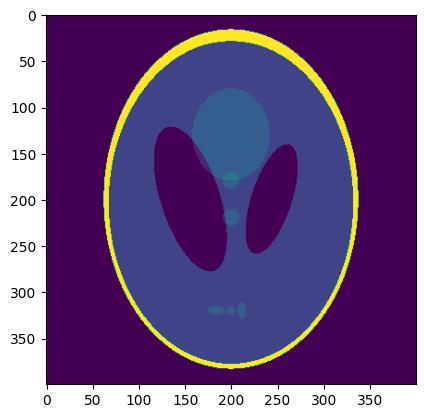

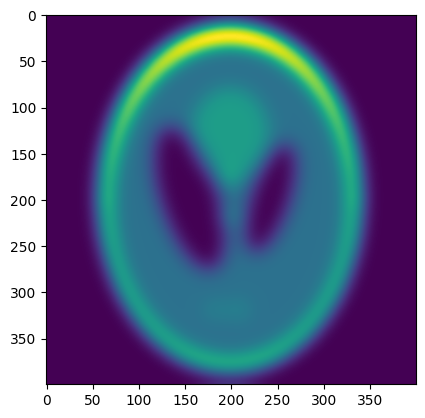

In [5]:
psf = generate_gaussian_psf(400, 10)
blur_img = fft_convolve_image(img,psf)
plt.imshow(img)
plt.show()
plt.imshow(blur_img)
plt.show()

Add Gaussian noise

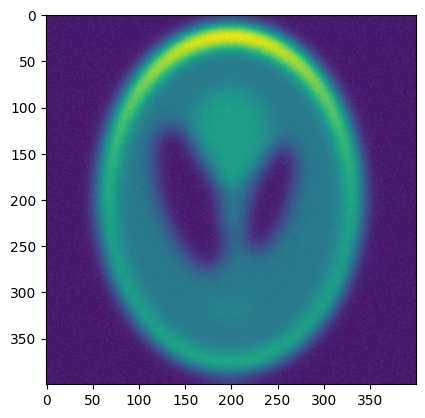

In [6]:
blur_noisy_img = blur_img + 0.01*torch.randn(img_dim)

plt.imshow(blur_noisy_img)
plt.show()

Deconvolve blurred & noisy image with Tikhonov regularization

In [24]:
def tikhonov(f, H, lam=0.1):
    """
    Perform Tikhonov regularization.

    Parameters:
    - f (torch.Tensor): 2D tensor representing the object.
    - H (torch.Tensor): 2D tensor representing the PSF.

    Returns:
    - torch.Tensor: 2D tensor representing the deconvolved image.
    """
    # Perform FFT of the object
    F = (torch.fft.fft2(f))

    # Perform FFT of the PSF (pupil function)
    H = (torch.fft.fft2(H))

    # Implement Tikhonov regularization
    Fhat = (torch.conj(H)*F)/ (torch.square(torch.abs(H))+lam)
    fhat = torch.real((torch.fft.ifftshift(torch.fft.ifft2(Fhat), dim=(-2, -1))))

    return fhat

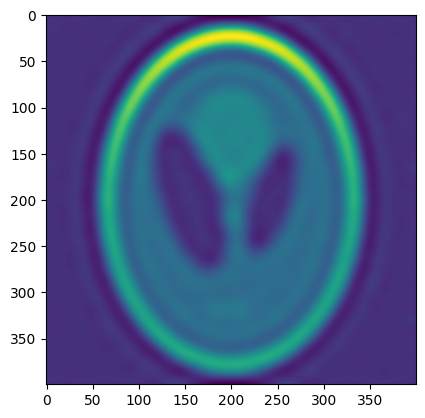

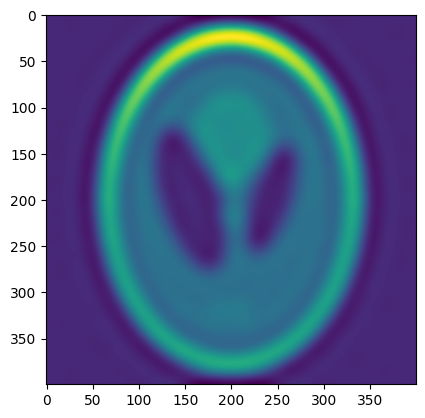

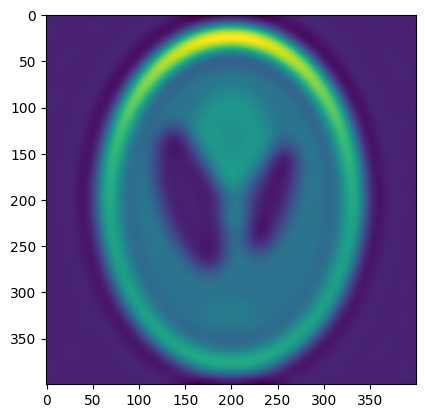

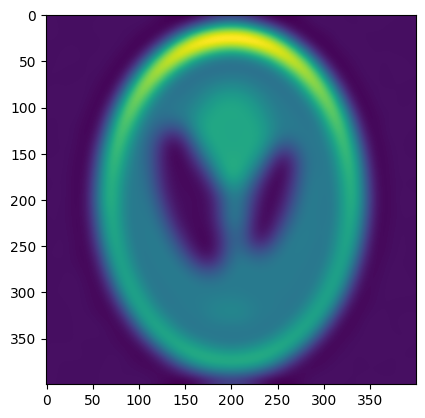

In [26]:
tik_img = tikhonov(blur_noisy_img,psf,lam=0.01)
plt.imshow(tik_img)
plt.show()

tik_img = tikhonov(blur_noisy_img,psf,lam=0.05)
plt.imshow(tik_img)
plt.show()

tik_img = tikhonov(blur_noisy_img,psf,lam=0.1)
plt.imshow(tik_img)
plt.show()

tik_img = tikhonov(blur_noisy_img,psf,lam=0.5)
plt.imshow(tik_img)
plt.show()